### Field data analysis at maximum elevation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.ndimage as ndimage
import re
import matplotlib.dates as md
import datetime as dt

# This ensures visualizations are plotted inside the notebook
%matplotlib inline

In [2]:
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [3]:
def pixel_map (data):
    
    nBars = 30
    N = len(data)
    hits = []
    matrix = np.zeros((nBars,nBars))
    sum_columns = np.zeros(nBars)
    sum_rows = np.zeros(nBars)

    sum_cl1 = 0
    sum_cl2 = 0
    sum_cl3 = 0

    sum_rw1 = 0
    sum_rw2 = 0
    sum_rw3 = 0

    Eventos = 0

    for k in range (N):

        columns = np.concatenate((data[k,0:27], data[k,29:32]), axis=0)
        rows = np.concatenate((data[k,32:35], data[k,37:64]), axis=0)

        if (np.sum(columns) == 1):    # Condición de activación de una barra por capa horizontal
            if (np.sum(rows) == 1):   # Condición de activación de una barra por capa vertical

                Eventos += 1
                hits.append(data[k,:])

                for i in range(nBars):   # Rows
                    for j in range(nBars):  # Columns

                        matrix[i,j]= matrix[i,j] + rows[i]*columns[j]

        #if (np.sum(columns) == 1):    # Condición de activación de una barra por capa horizontal
        #    if (np.sum(rows) == 1):   # Condición de activación de una barra por capa vertical

         #       Eventos += 1

    matrix = np.fliplr(matrix)  # Matrix reordering

    print 'Numero de eventos = ' + str(Eventos)
    print 'SNR = ' + str(100*Eventos/float(N))
    
    # 2D histogram plot
    
    fig = plt.figure(figsize=(35, 8))
    ax = fig.add_subplot(131)
    ax.set_xlabel('Columns', fontsize = 25)
    ax.set_ylabel('Rows', fontsize = 25)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.invert_yaxis()
    im = plt.imshow(matrix, interpolation='nearest', origin='low')

    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # Color bar
    clb = plt.colorbar()
    clb.set_label('Hits', fontsize = 25)

    # Increase tick labels
    ax.tick_params(axis='both', which='major', labelsize=25)
    
    # 1D histogram
    
    # Channels histogram

    hist = np.sum(hits, axis=0)
    chs = np.linspace(0, 63, num=64)
    
    
    fig = plt.figure(figsize=(15, 5))
    plt.bar(chs, hist, alpha=0.5)
    plt.axvline(x=32, color='r', lw=2)
    #plt.text(15, 1100, "x bars", fontsize=20)
    #plt.text(45, 1100, "y bars", fontsize=20)
    plt.xlabel('Channel', fontsize = 25)
    plt.ylabel('Counts', fontsize = 25)
    plt.grid()
    

    return matrix

In [6]:
def match(file, address, p1_mat, p2_mat, window):
    
    fine_Res = 25
    coarse_Res = 400
    counter = 0

    len_P1 = len(p1_mat)
    len_P2 = len(p2_mat)

    file.write("# s " + address + "\n")
    
    if len_P1 <= len_P2:
        file.write("# r " + str(len_P1) + "\n")
    else:
        file.write("# r " + str(len_P2) + "\n")
    
    for i in range (len_P1):
        line_P1 = re.split(r'\t+', p1_mat[i])
        time_P1 = int(line_P1[3])
        fine_P1 = int(line_P1[1])*fine_Res
        coarse_P1 = int(line_P1[2])*coarse_Res
        ToF_P1 = fine_P1 + coarse_P1
        
        for j in range (len_P2):
            line_P2 = re.split(r'\t+', p2_mat[j])
            time_P2 = int(line_P2[3])
            fine_P2 = int(line_P2[1])*fine_Res
            coarse_P2 = int(line_P2[2])*coarse_Res
            ToF_P2 = fine_P2 + coarse_P2
            
            av_ToF = (ToF_P1 + ToF_P2)/2.0
            error = np.absolute(time_P1-time_P2)
             
            if  error < window:
                #print "Time P1 = " + str(time_P1) + "  Time P2 = " + str(time_P2) + "  error = " + str(error)
                
                file.write(str(counter) + "\t" + str(time_P1) + "   \t" +  str(error) + "\t" + str(av_ToF)  + "\t" + line_P1[4][:-1] + "\t" + line_P2[4][:-1] + "\n")
                counter += 1


### Frontal

In [5]:
data = np.loadtxt('Field_Data/Hodoscope/02_2020/clean/MuTe_P1_2020_02_11h12.dat','string', comments='#')
N = len(data)
print ('Pulsos = ' + str(N))

Pulsos = 16454


In [6]:
# Extract the events from the data

n_Chann = 64
events = np.zeros((N,n_Chann))

for i in range(N):

    x=(" ".join(data[i][4]))
    lin=map(int ,x.split(' '))
    if len(lin) == n_Chann:  # Lines with legth greater than 64
        events[i,:]=lin
    else:
        print ("Line : ") + str(i)

In [7]:
hist = np.sum(events, axis=0)
chs = np.linspace(0, 63, num=64)

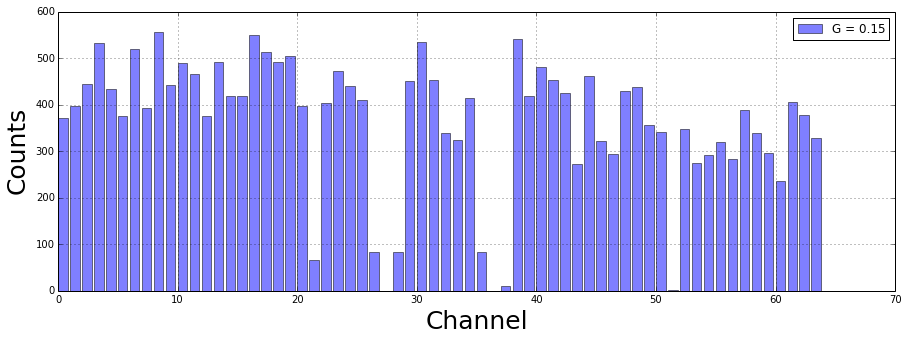

In [8]:
fig = plt.figure(figsize=(15, 5))
plt.bar(chs, hist, alpha=0.5)
plt.xlabel('Channel', fontsize = 25)
plt.ylabel('Counts', fontsize = 25)
plt.legend(["G = 0.15", "Calibrated"])
plt.grid()

Numero de eventos = 1928
SNR = 11.7175154978


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


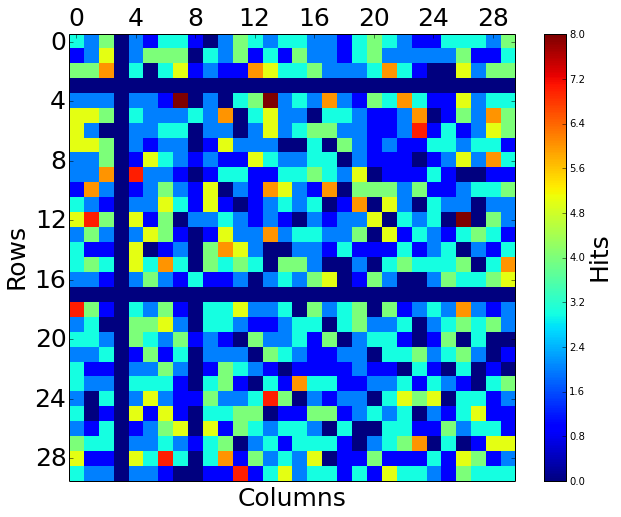

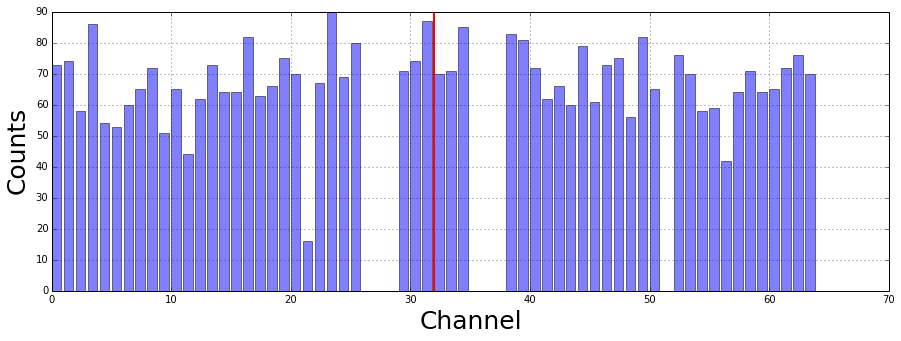

In [9]:
mat = pixel_map(events)

### Real panel

In [19]:
data = np.loadtxt('Field_Data/Hodoscope/02_2020/clean/MuTe_P2_2020_02_11h00.dat','string', comments='#')
N = len(data)
print ('Pulsos = ' + str(N))

Pulsos = 15259


In [20]:
# Extract the events from the data

events = np.zeros((N,64))

for i in range(N):

    x=(" ".join(data[i][4]))
    lin=map(int ,x.split(' '))
    if len(lin) == 64:
        events[i,:]=lin

In [21]:
hist = np.sum(events, axis=0)
chs = np.linspace(0, 63, num=64)

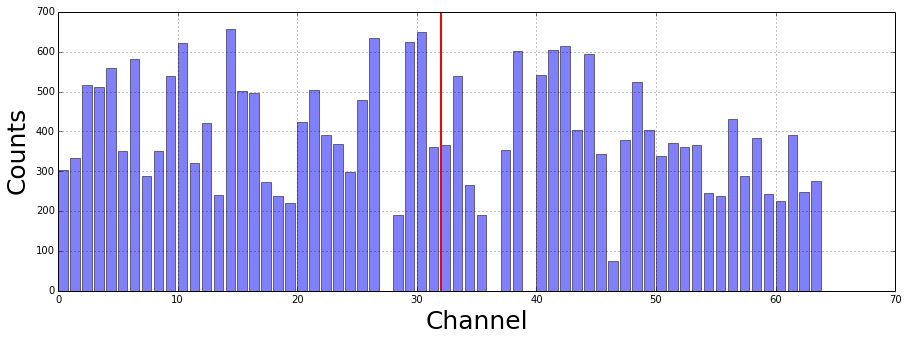

In [22]:
fig = plt.figure(figsize=(15, 5))
plt.bar(chs, hist, alpha=0.5)
plt.axvline(x=32, color='r', lw=2)
plt.xlabel('Channel', fontsize = 25)
plt.ylabel('Counts', fontsize = 25)
#plt.legend(["G = 0.15", "Calibrated"])
plt.grid()

Numero de eventos = 1674
SNR = 10.9705747428


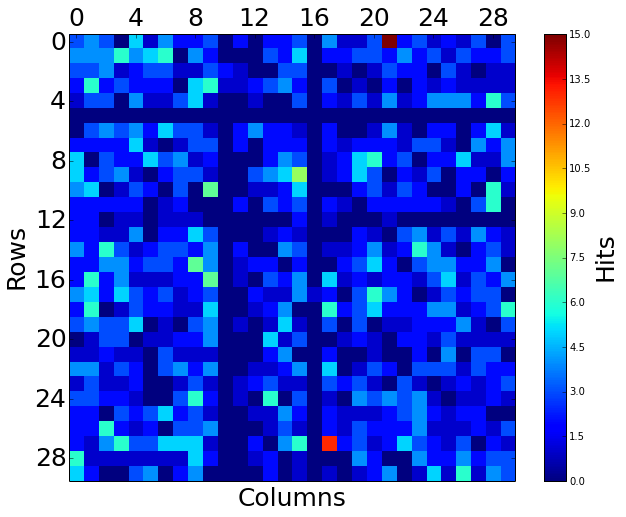

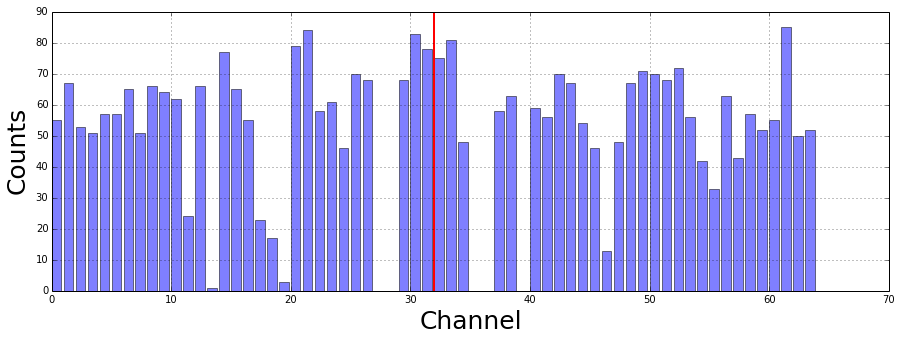

In [23]:
mat = pixel_map(events)

### Montly analysis

In [30]:
file = open("Field_Data/Hodoscope/02_2020/results/match_2020_02.dat", 'w')

panel_file = 0

for j in range(11,12):
    
    day = str(j).zfill(2)
    
    print day
    
    for i in range (15):

        try:
            
            hour = str(i).zfill(2)

            file_Panel_1 = 'Field_Data/Hodoscope/02_2020/clean/MuTe_P1_2020_02_' + day + 'h' + hour + '.dat'
            file_Panel_2 = 'Field_Data/Hodoscope/02_2020/clean/MuTe_P2_2020_02_' + day + 'h' + hour + '.dat'

            #print hour,

            count = 0
            for line in open(file_Panel_1).xreadlines(  ): count += 1

            #print ("Number of lines P1: ") + str(count)

            count = 0
            for line in open(file_Panel_2).xreadlines(  ): count += 1

            #print ("Number of lines P2: ") + str(count)

            # Init time determination


            with open(file_Panel_1) as f:
                i = 0
                panel_file = 1
                for line in f:

                    if line[0] == '#':
                        if line[2] == 's':
                            init_Time1 = int(line[4:15])
                            L1 = i
                            #print "Time P1 : " + str(init_Time1) + " Line : " + str(L1)
                            break
                    i+= 1

            with open(file_Panel_2) as f:
                i = 0
                panel_file = 2
                for line in f:
                    if line[0] == '#':
                        if line[2] == 's':
                            init_Time2 = int(line[4:15])
                            L2 = i
                            #print "Time P2 : " + str(init_Time2) + " Line : " + str(L2)
                            break
                    i += 1

            # Tree data creation

            with open(file_Panel_1) as P1:

                p1_Dic={}
                array = []
                for line in P1:

                    if line[0] != '#':
                        array.append(line)


                    if line[0] == '#':
                        if line[2] == 's':
                            address = line[4:14]
                            p1_Dic[address] = array
                            array = []


            with open(file_Panel_2) as P2:

                p2_Dic={}
                array = []
                for line in P2:

                    if line[0] != '#':
                        array.append(line)

                    if line[0] == '#':
                        if line[2] == 's':
                            address = line[4:14]
                            p2_Dic[address] = array
                            array = []

            # Coincidence file creation

            nevents_P1 = len(p1_Dic)
            nevents_P2 = len(p2_Dic)

            file = open("Field_Data/Hodoscope/02_2020/results/match_2020_02.dat", 'a')

            window = 800000 # 400
            match_counter = 0

            for i in range(3600):
                i+=1
                address_P1 = str(init_Time1 + i)
                address_P2 = str(init_Time1 + i)    # P2 time matching
                if p1_Dic.get(address_P1) != None:
                        if p2_Dic.get(address_P2) != None:
                            # print "Addresses: " + address_P1 + " " + address_P2
                            p1_mat = p1_Dic[address_P1]
                            p2_mat = p2_Dic[address_P2]
                            match(file, address_P1, p1_mat, p2_mat, window)
                            match_counter += 1

            file.close() 

            # print "Seconds matched = " + str(match_counter) + "\n"
            
        except:
            
            print 'Error at hour -> ' + hour + ' Panel ' + str(panel_file)


11
Error at hour -> 02 Panel 2


In [31]:
nBars =  30         # Number of bars per axis
Nd = (2*nBars-1)    # Number of trajectories
C = nBars-1         # Shiffting index

matrix_P1 = np.zeros((nBars,nBars))
matrix_P2 = np.zeros((nBars,nBars))


matrix_ang = np.zeros((Nd,Nd))

sum_columns = np.zeros(nBars)
sum_rows = np.zeros(nBars)

sum_cl1 = 0
sum_cl2 = 0
sum_cl3 = 0

sum_rw1 = 0
sum_rw2 = 0
sum_rw3 = 0

evento = 0

with open('Field_Data/Hodoscope/02_2020/results/match_2020_02.dat') as Hits:
    
    for line in Hits:
        if line[0] != '#' and line[0] != '\t' and line[0] != '\n':
        
            
            split_line = re.split(r'\t+', line)
            P1 = split_line[4]
            P2 = split_line[5]
            
            try:
                # Panel 1 
            
                columns_P1 = map(int ,(" ".join(P1[0:27] + P1[29:32])).split(' '))
                rows_P1 = map(int ,(" ".join(P1[32:35] + P1[37:64])).split(' '))
    
                # Panel 2 
    
                columns_P2 = map(int ,(" ".join(P2[0:27] + P2[29:32])).split(' '))
                rows_P2 = map(int ,(" ".join(P2[32:35] + P2[37:64])).split(' '))
            
    
                suma_P1_col = np.sum(columns_P1) 
                suma_P1_row =  np.sum(rows_P1)
                suma_P2_col =  np.sum(columns_P2)
                suma_P2_row =  np.sum(rows_P2)
    
                evento = evento + 1
            
            except ValueError as e:
                print "Error at event " + split_line[1] + "\n"
        
            if (suma_P1_col == 1 and suma_P1_row == 1 and suma_P2_col == 1 and suma_P2_row == 1):   # Condición de activación de solo 4 barras
                for i in range(nBars):
                    for j in range(nBars):
            
                        matrix_P1[i,j]= rows_P1[i]*columns_P1[j]
                        matrix_P2[i,j]= rows_P2[i]*columns_P2[j]
        
                if (np.sum(matrix_P1) == 1 and np.sum(matrix_P2) == 1):
    
                    for i in range(nBars):
                        for j in range(nBars):
            
                            if matrix_P1[i,j]== 1:
                                iP1 = i
                                jP1 = j
                            if matrix_P2[i,j]== 1:
                                iP2 = i
                                jP2 = j

                    evento = evento + 1
                    
                    h = iP1 - iP2
                    b = jP1 - jP2
            
                    matrix_ang[h+C,b+C]= matrix_ang[h+C,b+C] + 1
                
            
print 'Número de eventos en ambos paneles = ' + str(evento) + '\n'
print matrix_ang

Error at event 50044793   

Número de eventos en ambos paneles = 100982

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
sep = 250.0
base = 120.0
theta = int(np.rad2deg(np.arctan(base/sep)))/float(nBars)
theta*nBars

25.0

maximum hits = 5.0
minimum hits = 0.0


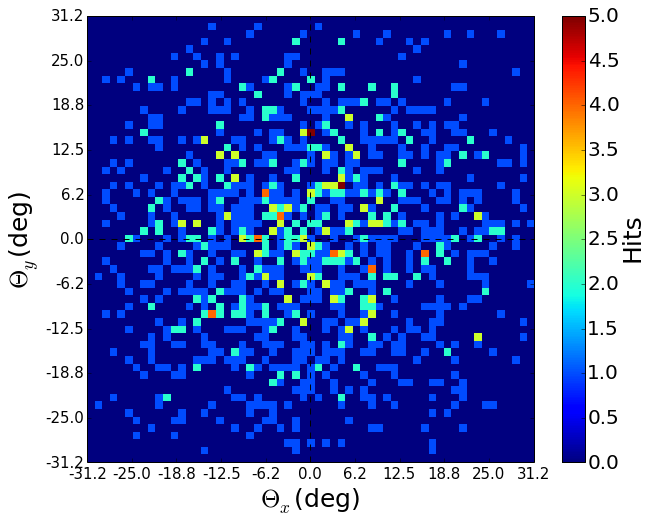

In [33]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(35, 8))
ax = fig.add_subplot(131)
ax.set_xlabel("$\Theta_x$(deg)", fontsize = 25)
ax.set_ylabel("$\Theta_y$(deg)", fontsize = 25)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

extent=(-nBars*theta,nBars*theta,-nBars*theta,nBars*theta)
im = plt.imshow(matrix_ang, interpolation='nearest', extent=extent, origin='lower')

#ax.xaxis.tick_top()


# Color bar
clb = plt.colorbar()
clb.set_label('Hits', fontsize = 25)
clb.ax.tick_params(labelsize = 20)

Nt = Nd
# Set tick labels

labelsx = np.round(np.linspace(-nBars*theta*1.25, nBars*theta*1.25, 11),1)
labelsy = np.round(np.linspace(-nBars*theta*1.25, nBars*theta*1.25, 11),1)

ax.set_xticklabels(labelsx)
ax.set_yticklabels(labelsy)

# center location
plt.axvline(x=0, color='k', lw=1, linestyle='--')
plt.axhline(y=0, color='k', lw=1, linestyle='--')

# Increase tick labels
ax.tick_params(axis='both', which='major', labelsize=15)


#fig.savefig('Fondo.jpg')
#labelsx

print "maximum hits = " + str(np.max(matrix_ang))
print "minimum hits = " + str(np.min(matrix_ang))

### Acceptance

In [34]:
nBars = 30

Nd = (2*nBars-1)    # Number of trajectories
C = nBars-2         # Shiffting index

acceptance = np.zeros((Nd,Nd))

matrix_P1 = np.zeros((nBars, nBars))
matrix_P2 = np.ones((nBars, nBars))

for i in range(nBars):
    for j in range(nBars):
        matrix_P1[i,j] = 1
        for k in range(nBars):
            for l in range(nBars):

                if matrix_P1[i,j]== 1:
                    iP1 = i
                    jP1 = j
                if matrix_P2[k,l]== 1:
                    iP2 = k
                    jP2 = l

                h = iP1 - iP2
                b = jP1 - jP2

                acceptance[h+C,b+C]= acceptance[h+C,b+C] + 1

In [35]:
d = 4       # 4 Pixel size
A = d**2    #  Pixel area
D = 250.0  # 134 Panel separation
d_Omega =  A/(D**2)
print "Angular resolution = " + str(d_Omega)

theta = int(np.rad2deg(np.arctan(d*nBars/D)))/float(nBars)
acceptance = acceptance*d_Omega*A

Angular resolution = 0.000256


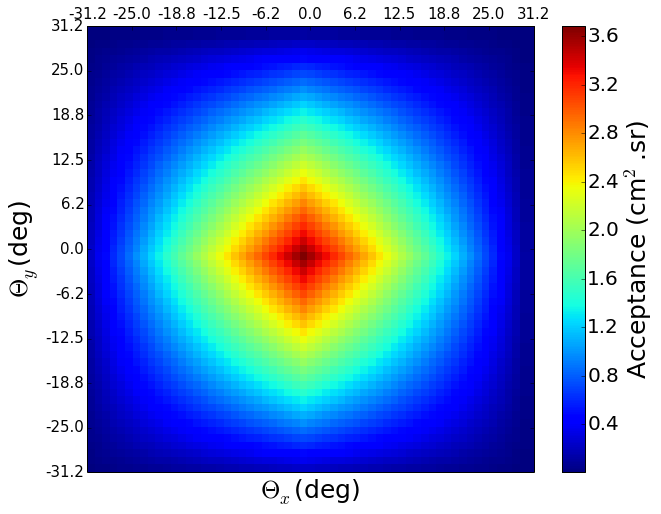

In [36]:

fig = plt.figure(figsize=(35, 8))
ax = fig.add_subplot(131)
ax.set_xlabel("$\Theta_x$(deg)", fontsize = 25)
ax.set_ylabel("$\Theta_y$(deg)", fontsize = 25)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

extent=(-nBars*theta,nBars*theta,-nBars*theta,nBars*theta)
im = plt.imshow(acceptance, interpolation='nearest', extent=extent, origin='lower')

ax.xaxis.tick_top()


# Color bar
clb = plt.colorbar()
clb.set_label('Acceptance (cm$^2$.sr)', fontsize = 25)
clb.ax.tick_params(labelsize = 20)

Nt = Nd
# Set tick labels

labelsx = np.round(np.linspace(-nBars*theta*1.25, nBars*theta*1.25, 11),1)
labelsy = np.round(np.linspace(-nBars*theta*1.25, nBars*theta*1.25, 11),1)
#ax.set_xticks(np.arange(Nt))
#ax.set_yticks(np.arange(Nt))
ax.set_xticklabels(labelsx)
ax.set_yticklabels(labelsy)


# Increase tick labels
ax.tick_params(axis='both', which='major', labelsize=15)

In [66]:
dias = 1
horas = 15
delta_T = dias*horas*3600

Nd = (2*nBars-1)    # Number of trajectories

I_flux = np.zeros((Nd,Nd))

for i in range(Nd):
    for j in range(Nd):
        
        I_flux[i,j] = matrix_ang[i,j]/(delta_T*acceptance[i,j])
        
        if I_flux[i,j] > 0.00012:
            I_flux[i,j] = 0

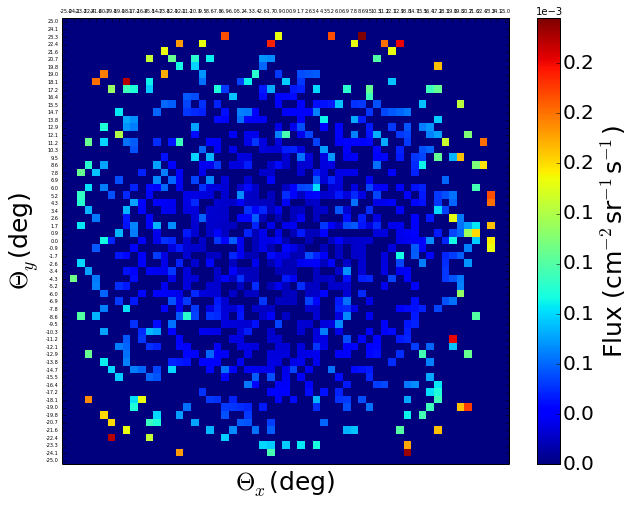

In [67]:
fig = plt.figure(figsize=(35, 8))
ax = fig.add_subplot(131)
ax.set_xlabel("$\Theta_x$(deg)", fontsize = 25)
ax.set_ylabel("$\Theta_y$(deg)", fontsize = 25)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

im = plt.imshow(I_flux*1.87 , interpolation='nearest', origin='low')

ax.xaxis.tick_top()

# Color bar
clb = plt.colorbar(format=OOMFormatter(-3, mathText=False))
clb.set_label('Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$)', fontsize = 25)
clb.ax.tick_params(labelsize = 20)

Nt = Nd
# Set tick labels
labelsx = np.round(np.linspace(-nBars*theta, nBars*theta, Nt),1)
labelsy = np.round(np.linspace(-nBars*theta, nBars*theta, Nt),1)
ax.set_xticks(np.arange(Nt))
ax.set_yticks(np.arange(Nt))
ax.set_xticklabels(labelsx)
ax.set_yticklabels(labelsy)


# Increase tick labels
ax.tick_params(axis='both', which='major', labelsize=5)

#fig.savefig('Fondo.jpg')
#labelsx

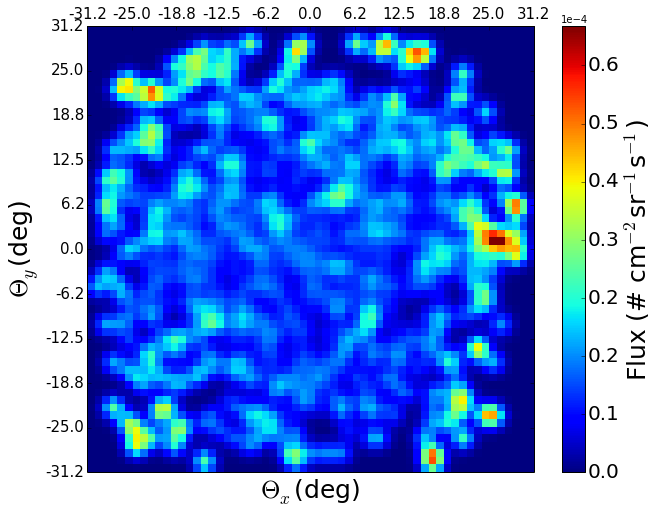

In [68]:
img_flux = ndimage.gaussian_filter(I_flux, sigma=(1), order=0)

fig = plt.figure(figsize=(35, 8))
ax = fig.add_subplot(131)
ax.set_xlabel("$\Theta_x$(deg)", fontsize = 25)
ax.set_ylabel("$\Theta_y$(deg)", fontsize = 25)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

extent=(-nBars*theta,nBars*theta,-nBars*theta,nBars*theta)
im = plt.imshow(img_flux*1.87, interpolation='nearest', extent=extent, origin='lower')

ax.xaxis.tick_top()

# Color bar

clb = plt.colorbar(format=OOMFormatter(-4, mathText=False))
clb.set_label('Flux (# cm$^{-2}$sr$^{-1}$s$^{-1}$)', fontsize = 25)
clb.ax.tick_params(labelsize = 20)

Nt = Nd
# Set tick labels

labelsx = np.round(np.linspace(-nBars*theta*1.25, nBars*theta*1.25, 11),1)
labelsy = np.round(np.linspace(-nBars*theta*1.25, nBars*theta*1.25, 11),1)
#ax.set_xticks(np.arange(Nt))
#ax.set_yticks(np.arange(Nt))
ax.set_xticklabels(labelsx)
ax.set_yticklabels(labelsy)


# Increase tick labels
ax.tick_params(axis='both', which='major', labelsize=15)

### Open sky flux

In [50]:
open_sky = np.loadtxt("Open_Sky_Flux_Buc.dat")

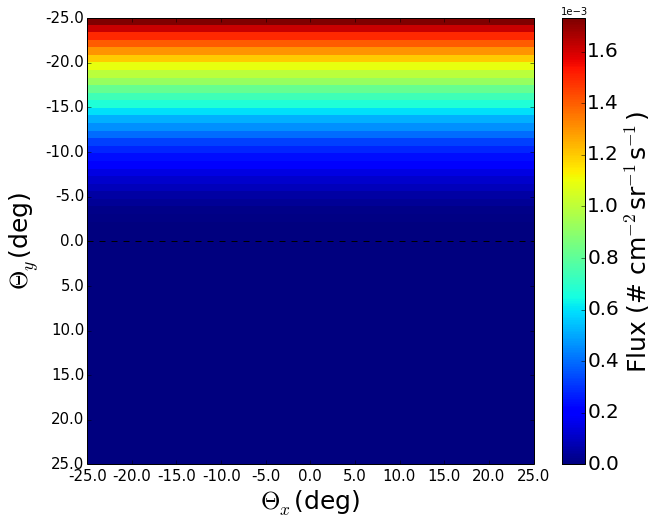

In [51]:
fig = plt.figure(figsize=(35, 8))
ax = fig.add_subplot(131)
ax.set_xlabel("$\Theta_x$(deg)", fontsize = 25)
ax.set_ylabel("$\Theta_y$(deg)", fontsize = 25)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

extent=(-nBars*theta,nBars*theta,-nBars*theta,nBars*theta)
im = plt.imshow(open_sky, interpolation='nearest', extent=extent, origin='lower')
plt.axhline(0, color='k', ls= '--') # horizont

#ax.xaxis.tick_top()
ax.invert_yaxis()

# Color bar

clb = plt.colorbar(format=OOMFormatter(-3, mathText=False))
clb.set_label('Flux (# cm$^{-2}$sr$^{-1}$s$^{-1}$)', fontsize = 25)
clb.ax.tick_params(labelsize = 20)

Nt = Nd
# Set tick labels


labelsx = np.round(np.linspace(-nBars*theta, nBars*theta, 11),1)
labelsy = np.round(np.linspace(-nBars*theta, nBars*theta, 11),1)

ax.set_xticklabels(labelsx)
ax.set_yticklabels(labelsy)

# Increase tick labels
ax.tick_params(axis='both', which='major', labelsize=15)

In [58]:
Diff_flux = np.zeros((Nd,Nd))
R = 1.87

for i in range(Nd):
    for j in range(Nd):
        
        Diff_flux[i,j] = open_sky[i,j] - R*img_flux[i,j]
        

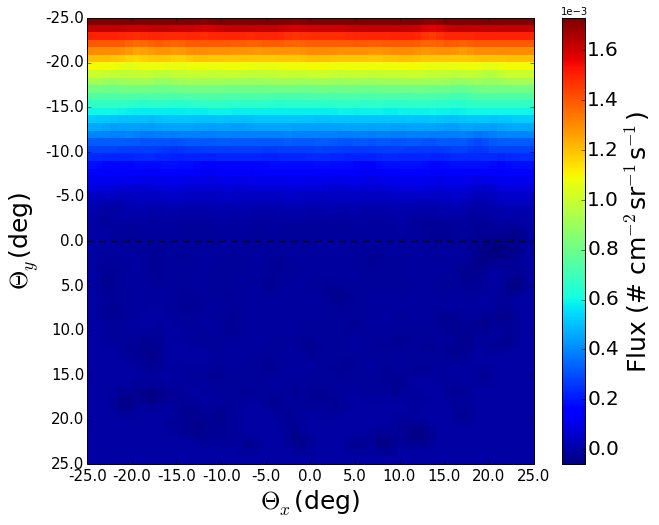

In [59]:
fig = plt.figure(figsize=(35, 8))
ax = fig.add_subplot(131)
ax.set_xlabel("$\Theta_x$(deg)", fontsize = 25)
ax.set_ylabel("$\Theta_y$(deg)", fontsize = 25)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

extent=(-nBars*theta,nBars*theta,-nBars*theta,nBars*theta)
im = plt.imshow(Diff_flux, interpolation='nearest', extent=extent, origin='lower')
plt.axhline(0, color='k', ls= '--') # horizont

#ax.xaxis.tick_top()
ax.invert_yaxis()

# Color bar

clb = plt.colorbar(format=OOMFormatter(-3, mathText=False))
clb.set_label('Flux (# cm$^{-2}$sr$^{-1}$s$^{-1}$)', fontsize = 25)
clb.ax.tick_params(labelsize = 20)

Nt = Nd
# Set tick labels

labelsx = np.round(np.linspace(-nBars*theta, nBars*theta, 11),1)
labelsy = np.round(np.linspace(-nBars*theta, nBars*theta, 11),1)

ax.set_xticklabels(labelsx)
ax.set_yticklabels(labelsy)


# Increase tick labels
ax.tick_params(axis='both', which='major', labelsize=15)

### Hybrid trigger analysis

In [13]:
Nim1 = np.loadtxt("Field_Data/Hodoscope/02_2020/Figures/trigger5_Ev1_Nim.dat")
Nim2 = np.loadtxt("Field_Data/Hodoscope/02_2020/Figures/trigger5_Ev2_Nim.dat")
Nim3 = np.loadtxt("Field_Data/Hodoscope/02_2020/Figures/trigger5_Ev3_Nim.dat")

Sig1 = np.loadtxt("Field_Data/Hodoscope/02_2020/Figures/trigger5_Ev1_Sig.dat")
Sig2 = np.loadtxt("Field_Data/Hodoscope/02_2020/Figures/trigger5_Ev2_Sig.dat")
Sig3 = np.loadtxt("Field_Data/Hodoscope/02_2020/Figures/trigger5_Ev3_Sig.dat")

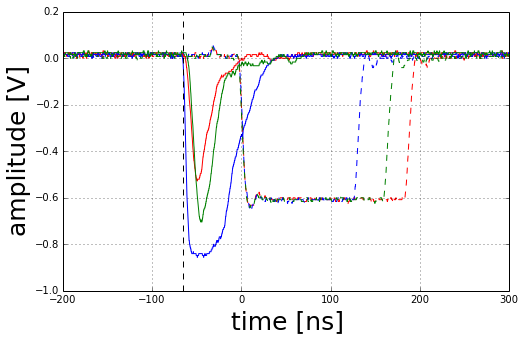

In [23]:
fig = plt.figure(figsize=(8, 5))
plt.plot(Nim1[:,0]*1e9, Nim1[:,1], '--r')
plt.plot(Nim2[:,0]*1e9, Nim2[:,1], '--b')
plt.plot(Nim3[:,0]*1e9, Nim3[:,1], '--g')
plt.plot(Nim1[:,0]*1e9, Sig1[:,1], 'r')
plt.plot(Sig2[:,0]*1e9, Sig2[:,1], 'b')
plt.plot(Sig3[:,0]*1e9, Sig3[:,1], 'g')
plt.axvline(-65, color='k', ls="--")
plt.xlabel('time [ns]', fontsize = 25)
plt.ylabel('amplitude [V]', fontsize = 25)
plt.grid()

In [16]:
Charge_t4 = np.loadtxt("Field_Data/Hodoscope/02_2020/Test2.dat")

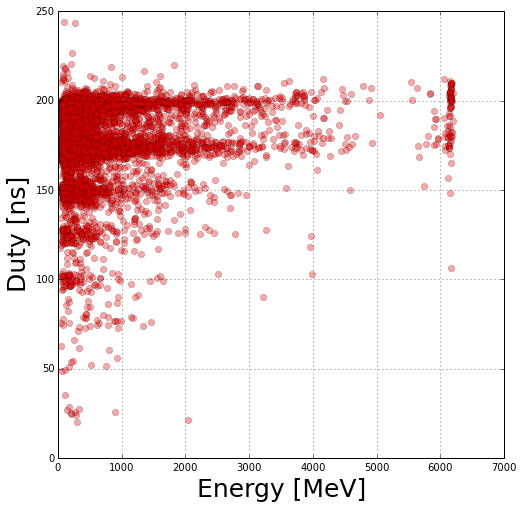

In [17]:
fig = plt.figure(figsize=(8, 8))
plt.plot(Charge_t4[:,0]*0.72, Charge_t4[:,1]/24.0, 'or', alpha=0.1)
plt.xlabel('Energy [MeV]', fontsize = 25)
plt.ylabel('Duty [ns]', fontsize = 25)
#plt.axis([0,1000,0,6000])
plt.grid()

In [18]:
N = len(Charge_t4)
L1 = np.zeros((N,2))
L2 = np.zeros((N,2))
L3 = np.zeros((N,2))
L4 = np.zeros((N,2))
j = 0
k = 0
m = 0
n = 0
for i in range(N):
    if Charge_t4[i,1] > 4400:
        L1[j,1] = Charge_t4[i,1]
        L1[j,0] = Charge_t4[i,0]
        j += 1
    if Charge_t4[i,1] > 3800 and Charge_t4[i,1] <= 4400:
        L2[k,1] = Charge_t4[i,1]
        L2[k,0] = Charge_t4[i,0]
        k += 1
    if Charge_t4[i,1] > 3200 and Charge_t4[i,1] <= 3800:
        L3[m,1] = Charge_t4[i,1]
        L3[m,0] = Charge_t4[i,0]
        m += 1
    if Charge_t4[i,1] > 2600 and Charge_t4[i,1] <= 3200:
        L4[n,1] = Charge_t4[i,1]
        L4[n,0] = Charge_t4[i,0]
        n += 1

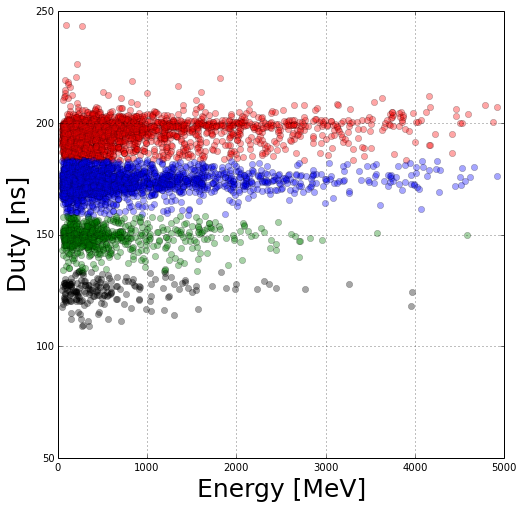

In [30]:
fig = plt.figure(figsize=(8, 8))
plt.plot(L1[:,0]*0.72, L1[:,1]/24.0, 'or', alpha=0.1)
plt.plot(L2[:,0]*0.72, L2[:,1]/24.0, 'ob', alpha=0.1)
plt.plot(L3[:,0]*0.72, L3[:,1]/24.0, 'og', alpha=0.1)
plt.plot(L4[:,0]*0.72, L4[:,1]/24.0, 'ok', alpha=0.1)
plt.xlabel('Energy [MeV]', fontsize = 25)
plt.ylabel('Duty [ns]', fontsize = 25)
plt.axis([0,5000,50,250])
plt.grid()

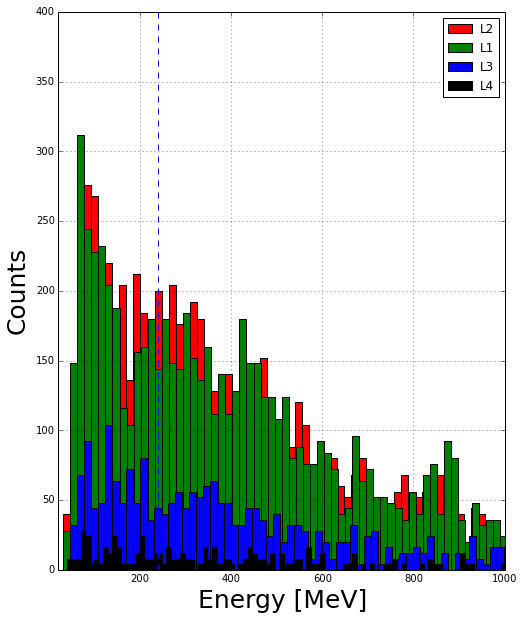

In [27]:
fig = plt.figure(figsize=(8, 10))
plt.hist(L2[:,0]*0.72, bins=400, color='r')
plt.hist(L1[:,0]*0.72, bins=400, color='g')
plt.hist(L3[:,0]*0.72, bins=400)
plt.hist(L4[:,0]*0.72, bins=400, color='k')
plt.xlabel('Energy [MeV]', fontsize = 25)
plt.ylabel('Counts', fontsize = 25)
plt.legend(["L2","L1","L3","L4"])
plt.axvline(240, ls="--")
plt.axis([20,1000,0,400])
plt.grid()

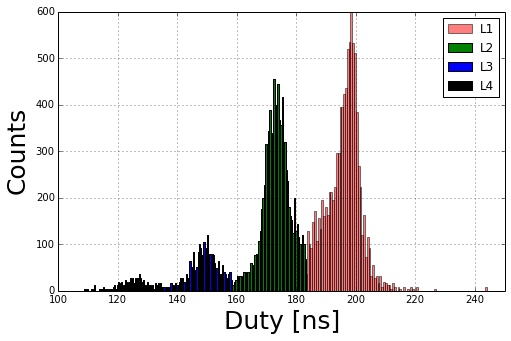

In [22]:
fig = plt.figure(figsize=(8, 5))
plt.hist(L1[:,1]/24.0, bins=400, color='r', alpha=0.5)
plt.hist(L2[:,1]/24.0, bins=400, color='g')
plt.hist(L3[:,1]/24.0, bins=400)
plt.hist(L4[:,1]/24.0, bins=400, color='k')
plt.xlabel('Duty [ns]', fontsize = 25)
plt.ylabel('Counts', fontsize = 25)
plt.legend(["L1","L2","L3","L4"])
#plt.axvline(240, ls="--")
plt.axis([100,250,0,600])
plt.grid()